In [3]:
import datasets
from pathlib import Path

In [121]:
home_dir = Path("/home/user/notebooks")
run_dir = home_dir / "experiments/polIter_rho1bSft2_ppo_GSM8K_devBz16_true_sfl_check_t1/temp_episodes"
iteration = run_dir / "iteration__0000"

# load the buffer
candidate_buffer = datasets.load_from_disk(iteration / "candidate_levels__0")
buffer = datasets.load_from_disk(iteration / "buffer__0")

infer_results = datasets.load_from_disk(iteration / "infer_results" / "process_00" / "results_ds")

In [122]:
candidate_buffer_idxs = candidate_buffer["_treetune__idx"]
print(f"Unique idxs in candidate buffer: {len(set(candidate_buffer_idxs))}")

Unique idxs in candidate buffer: 256


In [123]:
buffer_idxs = buffer["_treetune__idx"]
print(f"Unique idxs in buffer: {len(set(buffer_idxs))}")

Unique idxs in buffer: 64


In [124]:
print(f"Overlap between buffer and candidate buffer: {len(set(buffer_idxs) & set(candidate_buffer_idxs))}")

Overlap between buffer and candidate buffer: 64


In [125]:
infer_results_idxs = infer_results["_treetune__idx"]
print(f"Unique idxs in infer results: {len(set(infer_results_idxs))}")

Unique idxs in infer results: 64


In [126]:
print(f"Overlap between candidate buffer and infer results: {len(set(candidate_buffer_idxs) & set(infer_results_idxs))}")

Overlap between candidate buffer and infer results: 64


In [127]:
for iteration in range(1, 12):
    infer_results_next_iteration = run_dir / f"iteration__{iteration:04d}" / "infer_results" / "process_00" / "results_ds"
    infer_results_next_iteration = datasets.load_from_disk(infer_results_next_iteration)

    infer_results_next_iteration_idxs = infer_results_next_iteration["_treetune__idx"]
    print(f"Unique idxs in infer results iteration {iteration}: {len(set(infer_results_next_iteration_idxs))}")
    print(f"Overlap between infer results idx for iteration {iteration} and candidate buffer: {len(set(infer_results_next_iteration_idxs) & set(candidate_buffer_idxs))}")
    print(f"Overlap between infer results idx for iteration {iteration} and buffer: {len(set(infer_results_next_iteration_idxs) & set(buffer_idxs))}")
    print(f"Overlap between infer results idx for iteration {iteration} and infer results iteration 0: {len(set(infer_results_next_iteration_idxs) & set(infer_results_idxs))}")
    print()

Unique idxs in infer results iteration 1: 64
Overlap between infer results idx for iteration 1 and candidate buffer: 6
Overlap between infer results idx for iteration 1 and buffer: 2
Overlap between infer results idx for iteration 1 and infer results iteration 0: 2

Unique idxs in infer results iteration 2: 64
Overlap between infer results idx for iteration 2 and candidate buffer: 2
Overlap between infer results idx for iteration 2 and buffer: 1
Overlap between infer results idx for iteration 2 and infer results iteration 0: 1

Unique idxs in infer results iteration 3: 64
Overlap between infer results idx for iteration 3 and candidate buffer: 1
Overlap between infer results idx for iteration 3 and buffer: 0
Overlap between infer results idx for iteration 3 and infer results iteration 0: 0

Unique idxs in infer results iteration 4: 64
Overlap between infer results idx for iteration 4 and candidate buffer: 0
Overlap between infer results idx for iteration 4 and buffer: 0
Overlap between 

In [128]:
next_buffer = datasets.load_from_disk(run_dir / "iteration__0010" / "buffer__0")
next_buffer_idxs = next_buffer["_treetune__idx"]
print(f"Unique idxs in next buffer: {len(set(next_buffer_idxs))}")

Unique idxs in next buffer: 64


In [129]:
print(f"Overlap between buffer and next buffer: {len(set(buffer_idxs) & set(next_buffer_idxs))}")

Overlap between buffer and next buffer: 1


# Plotting episode scores

In [303]:
ls = [1,2,3]

In [304]:
ls.insert(0,0)

In [305]:
ls

[0, 1, 2, 3]

In [300]:
from transformers import AutoTokenizer
datasets.disable_progress_bars()

home_dir = Path("/home/user/notebooks")

i = 0
run_dir = home_dir / "experiments/polIter_rho1bSft2_ppo_GSM8K_devBz16_true_sfl_rec_config_gsm8k/temp_episodes"
episodes = datasets.load_from_disk(run_dir / f"iteration__{i:04d}" / "episodes" / "merged")
buffer = datasets.load_from_disk(run_dir / f"iteration__{i:04d}" / "buffer__0")

tokenizer = AutoTokenizer.from_pretrained("realtreetune/rho-1b-sft-MATH")

print(repr(tokenizer.decode(episodes["query_token_ids"][0])))
print(repr(tokenizer.decode(episodes["response_token_ids"][0])))
print(episodes["scores"][0])

def strip_prompt(prompt):
    return prompt.split("Problem:\n")[1].split("\n\nSolution:")[0]

stripped_prompt = strip_prompt(tokenizer.decode(episodes["query_token_ids"][0]))
print(stripped_prompt)

'<s> [MATH_TASK] Problem:\nJames drives 30 mph for half an hour and then twice as long for twice the speed.  How far did he drive in total?\n\nSolution:'
'\nHe drove 30/2=15 miles for the first part of the trip\nHe drove 15*2=30 miles for the second part of the trip\nSo in total he drove 15+30=45 miles\n#### 45\n</s>'
0.0
James drives 30 mph for half an hour and then twice as long for twice the speed.  How far did he drive in total?


In [242]:
from tqdm.notebook import tqdm

def get_scores(run_dir, T):

    scores_in_buffer = []
    scores_not_in_buffer = []

    for i in tqdm(range(241)):
        episodes = datasets.load_from_disk(run_dir / f"iteration__{i:04d}" / "episodes" / "merged")
        
        if i % T == 0:
            buffer = datasets.load_from_disk(run_dir / f"iteration__{i:04d}" / "buffer__0")

        prompts = tokenizer.batch_decode(episodes["query_token_ids"], skip_special_tokens=True)
        stripped_prompts = [strip_prompt(p) for p in prompts]
        episodes = episodes.add_column("stripped_prompts", stripped_prompts)
        buffer_problems = set(buffer["problem"])
        episodes_in_buffer = episodes.filter(lambda x : x["stripped_prompts"] in buffer_problems)
        episodes_not_in_buffer = episodes.filter(lambda x : x["stripped_prompts"] not in buffer_problems)
        
        if len(episodes_in_buffer) > 0:
            scores_in_buffer.append(np.mean(episodes_in_buffer["scores"]))
        else:
            scores_in_buffer.append(None)
            
        if len(episodes_not_in_buffer) > 0:
            scores_not_in_buffer.append(np.mean(episodes_not_in_buffer["scores"]))
        else:
            scores_not_in_buffer.append(None)
            
    return scores_in_buffer, scores_not_in_buffer

In [243]:
def compute_rolling_window(scores, window_size):
    scores = np.array(scores)
    scores = np.convolve(scores, np.ones(window_size) / window_size, mode='valid')
    return scores

def compute_line_of_best_fit(scores):
    scores = np.array(scores)
    x = np.arange(len(scores))
    x = x[~np.isnan(scores)]
    scores = scores[~np.isnan(scores)]
    m, b = np.polyfit(x, scores, 1)
    return m, b

In [244]:
home_dir = Path("/home/user/notebooks")

run_dirs = [
    (home_dir / "experiments/polIter_rho1bSft2_ppo_GSM8K_devBz16_true_sfl_rec_config_gsm8k/temp_episodes", 50),
    (home_dir / "experiments/polIter_rho1bSft2_ppo_GSM8K_devBz16_true_sfl_fast_config_gsm8k/temp_episodes", 10),
    (home_dir / "experiments/polIter_rho1bSft2_ppo_GSM8K_devBz16_true_sfl_very_fast_config_gsm8k/temp_episodes", 5),
    (home_dir / "experiments/polIter_rho1bSft2_ppo_GSM8K_devBz16_true_sfl_check_t1/temp_episodes", 1)
]

scores = [
    get_scores(run_dir, T) for run_dir, T in run_dirs
]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

In [295]:
!ls /src

ls: cannot access '/src': No such file or directory


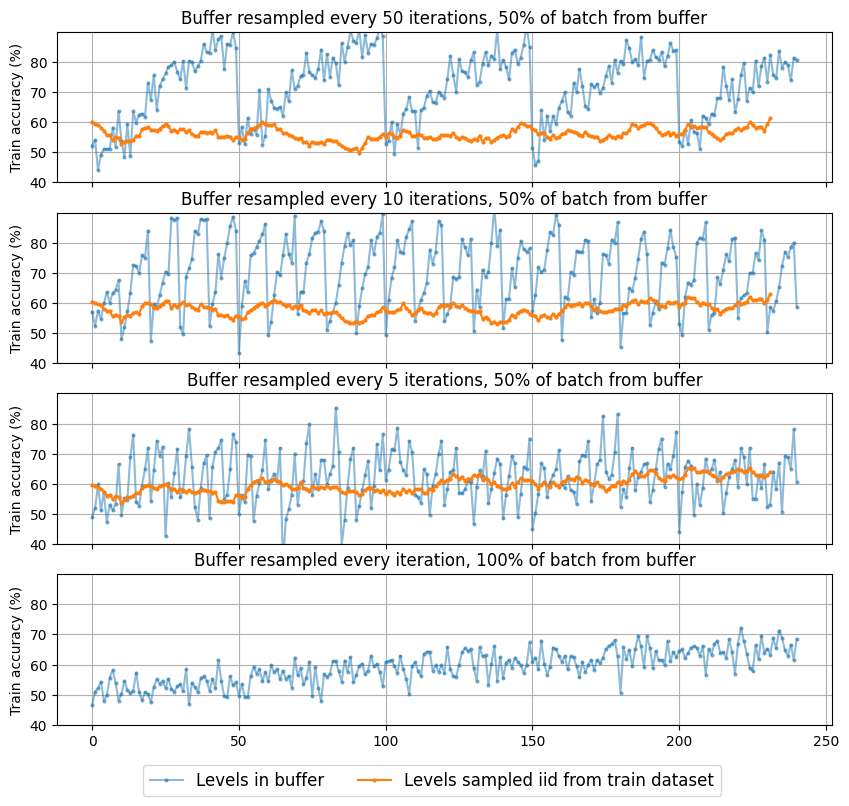

In [297]:
import matplotlib.pyplot as plt

def plot(scores_in_buffer, scores_not_in_buffer, axs):
    
    axs.plot(scores_in_buffer, label="Levels in buffer", marker='o', markersize=2.0, alpha=0.5)
    axs.grid(True)
    axs.set_ylim(0.4, 0.9)
    
    axs.set_yticks(np.arange(0.4, 0.9, 0.1), np.arange(40, 90, 10))

    # m, b = compute_line_of_best_fit(scores_in_buffer)
    # axs.plot(np.arange(len(scores_in_buffer)), m * np.arange(len(scores_in_buffer)) + b, label="In buffer line of best fit", linestyle="--", color='firebrick', alpha=1.0)
    
    if len([x for x in scores_not_in_buffer if x is not None]) > 0:
        scores_not_in_buffer = compute_rolling_window(scores_not_in_buffer, 10)
        axs.plot(scores_not_in_buffer, label="Levels sampled iid from train dataset", marker='o', markersize=2.0, alpha=1.0)
    #     m, b = compute_line_of_best_fit(scores_not_in_buffer)
    #     axs.plot(np.arange(len(scores_not_in_buffer)), m * np.arange(len(scores_not_in_buffer)) + b, label="Line of best fit", linestyle="-", color='black', alpha=1.0)

fig, axs = plt.subplots(4, 1, figsize=(10, 9), sharex=True)
for i, (scores_in_buffer, scores_not_in_buffer) in enumerate(scores):
    plot(scores_in_buffer, scores_not_in_buffer, axs[i])
    
# get common labels and put legend below buffer 
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.075), fontsize='large')

# place titles to the right of each plot
titles = [
    "Buffer resampled every 50 iterations, 50% of batch from buffer",
    "Buffer resampled every 10 iterations, 50% of batch from buffer",
    "Buffer resampled every 5 iterations, 50% of batch from buffer",
    "Buffer resampled every iteration, 100% of batch from buffer"
]
for i, title in enumerate(titles):
    axs[i].set_title(title, fontsize='large')
    
for i in range(len(axs)):
    axs[i].set_ylabel("Train accuracy (%)", fontsize='medium')
    
plt.savefig("/home/user/notebooks/tree sfl debug.pdf")


In [480]:
from transformers import AutoTokenizer
datasets.disable_progress_bars()

home_dir = Path("/home/user/notebooks")

i = 0
run_dir = home_dir / "experiments/polIter_rho1bSft2_ppo_MATH_devBz16"
run_dir = home_dir / "experiments/polIter_rho1bSft2_ppo_GSM8K_devBz16_adjust_temp_dir_gsm8k_sfl"
infer_results = datasets.load_from_disk(run_dir / 'temp_episodes' / f"iteration__{i:04d}" / "infer_results" / "process_00" / "results_ds")

In [481]:
infer_results[0]['solution'].split('\n')

['The long division is shown below.',
 '',
 '\\[',
 '\\begin{array}{c|cc cc}',
 '\\multicolumn{2}{r}{7x^2} & -11x & +17  \\\\',
 '\\cline{2-5}',
 'x + 2 & 7x^3 & +3x^2&-5x&-8  \\\\',
 '\\multicolumn{2}{r}{7x^3} & +14x^2& \\\\ ',
 '\\cline{2-3}',
 '\\multicolumn{2}{r}{} & -11x^2& -5x\\\\ ',
 '\\multicolumn{2}{r}{} & -11x^2& -22x\\\\ ',
 '\\cline{3-4}',
 '\\multicolumn{2}{r}{} & & +17x & -8 \\\\ ',
 '\\multicolumn{2}{r}{} & & +17x & +34 \\\\ ',
 '\\cline{4-5}',
 '\\multicolumn{2}{r}{} & & & -42 \\\\ ',
 '\\end{array}',
 '\\]Thus, the quotient is $\\boxed{7x^2 - 11x + 17}.$']

In [538]:
from tqdm.notebook import tqdm
import re 

def parse_answer(answer):
    # use re to find the answer inside \boxed{answer} adn remove latex
    # be careful to handle no matching answers case
    answer = re.search(r'\\boxed{(.+?)}', answer)
    if answer:
        return answer.group(1)
    else:
        return None
    
def parse_answer_gsm8k(answer):
    # use re to find the answer of the form "#### 32\m"
    # ie the answer is the last number in the string
    # and comes after 4 hashtags
    # be careful to handle no matching answers case
    answer = re.search(r'#### (\d+)', answer)
    if answer:
        return answer.group(1)
    else:
        return None
    

def get_num_steps_math(iteration):
    run_dir = home_dir / "experiments/polIter_rho1bSft2_ppo_MATH_devBz16"
    infer_results = datasets.load_from_disk(run_dir / 'temp_episodes' / f"iteration__{iteration:04d}" / "infer_results" / "process_00" / "results_ds")
    infer_results = infer_results.map(lambda x : {'num_steps': len(x["gold_solution_steps"])})
    infer_results = infer_results.map(lambda x : {'candidate_answers': [parse_answer(answer) for answer in x["_treetune__candidate_answers"]]})
    infer_results = infer_results.map(lambda x : {'correct': [x['answer'] == answer for answer in x['candidate_answers']]})
    infer_results = infer_results.map(lambda x : {'accuracy': np.mean(x['correct'])})
    infer_results = infer_results.map(lambda x : {'learnability': x['accuracy'] * (1-x['accuracy'])})
    return infer_results

def get_num_steps_gsm8k(iteration):
    run_dir = home_dir / "experiments/polIter_rho1bSft2_ppo_GSM8K_devBz16_adjust_temp_dir_gsm8k_sfl"
    infer_results = datasets.load_from_disk(run_dir / 'temp_episodes' / f"iteration__{iteration:04d}" / "infer_results" / "process_00" / "results_ds")
    infer_results = infer_results.map(lambda x : {'num_steps': len(x["solution"].split('\n'))})
    infer_results = infer_results.map(lambda x : {'candidate_answers': [parse_answer_gsm8k(answer) for answer in x["_treetune__candidate_answers"]]})
    infer_results = infer_results.map(lambda x : {'num_candidate_answer_steps': [len(answer.split('\n')) for answer in x["_treetune__candidate_answers"]]})
    infer_results = infer_results.map(lambda x : {'avg_num_candidate_answer_steps': np.mean(x['num_candidate_answer_steps'])})
    infer_results = infer_results.map(lambda x : {'correct': [x['answer'] == answer for answer in x['candidate_answers']]})
    infer_results = infer_results.map(lambda x : {'accuracy': np.mean(x['correct'])})
    infer_results = infer_results.map(lambda x : {'learnability': x['accuracy'] * (1-x['accuracy'])})
    return infer_results
    

In [568]:
def compute_time_weighted_emas(ys, alpha):
    """Replicate the wandb time weighted EMA algo in python"""
    y = ys[0]
    y_avg = []
    last_y = 0
    debias_weight = 0
    for i in range(1, len(ys)):
        change_in_x = 1
        smoothing_weight_adj = alpha ** change_in_x
        last_y = last_y * smoothing_weight_adj + ys[i]
        debias_weight = debias_weight * smoothing_weight_adj + 1
        y_avg.append(last_y / debias_weight)
    return y_avg
    

In [540]:
def get_data(get_func, max_t, stride):
    xs = []
    ys = []
    ys_hat = []
    all_num_steps = [None] * max_t
    all_num_steps_buffer = [None] * max_t
    for i in tqdm(range(0, max_t, stride)):
        x = get_func(i)
        # x = get_num_steps_gsm8k(i)
        x = x.sort("learnability", reverse=True)
        buffer = x.select(range(64))
        xs.append(i)
        ys.append(np.mean(buffer["num_steps"]))  
        ys_hat.append(np.mean(x["num_steps"]))  
        all_num_steps[i] = x["num_steps"]
        all_num_steps_buffer[i] = buffer["num_steps"]
        
    return {
        'xs': xs,
        'ys': ys,
        'ys_hat': ys_hat,
        'all_num_steps': all_num_steps,
        'all_num_steps_buffer': all_num_steps_buffer
    }

In [745]:
x = get_num_steps_math(0)
x = x.filter(lambda x : x['learnability'] > 0.24 and x['num_steps'] < 4)

In [746]:
x

Dataset({
    features: ['problem', 'solution', 'answer', 'subject', 'level', 'unique_id', 'gold_solution_steps', '_treetune__idx', 'gold_solution_steps_str', 'query', '_treetune__reasoning_tree', '_treetune__candidate_answers', '_treetune__candidate_logprobs', '_treetune__candidate_num_tokens', 'num_steps', 'candidate_answers', 'correct', 'accuracy', 'learnability'],
    num_rows: 2
})

In [761]:
i = 0

In [769]:
print(x[i]['num_steps'])
print(x['problem'][i])
print(x['solution'][i])
print(x['answer'][i])
print(x['accuracy'][i])
print(x['learnability'][i])

3
If the sum of the squares of nonnegative real numbers $a,b,$ and $c$ is $13$, and $ab + bc + ca = 6$, then what is the sum of $a,b,$ and $c$?
Since $$(a+b+c)^2 = a^2 + b^2 + c^2 + 2ab + 2bc + 2ca = (13) + 2(6) = 25,$$ it follows that $a+b+c = \pm 5$. Since $a,b,c \ge 0$ we find $a+b+c=\boxed{5}$.
5
0.5
0.25


In [728]:
data_gsm8k = get_data(get_num_steps_gsm8k, 1000, 1)
data_math = get_data(get_num_steps_math, 550, 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

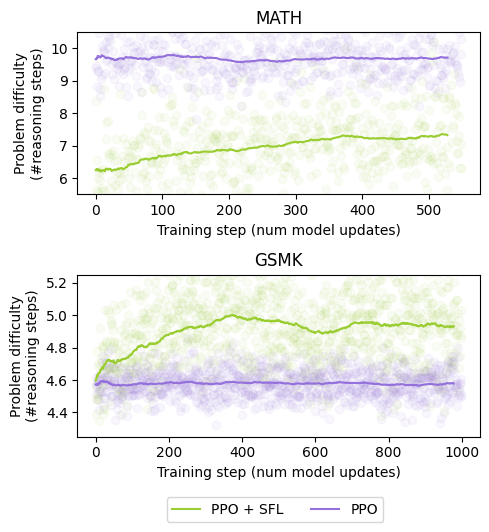

In [772]:
fig, axs = plt.subplots(2, 1, figsize=(5, 5))

ys = data_math['ys']
ys_hat = data_math['ys_hat']
smooth_ys = compute_time_weighted_emas(ys, 0.99)
smooth_ys_hat = compute_time_weighted_emas(ys_hat, 0.99)
axs[0].set_title("MATH")
axs[0].set_xlabel("Training step (num model updates)")
axs[0].set_ylabel("Problem difficulty\n(#reasoning steps)")
axs[0].scatter(range(len(ys)), ys, alpha=0.05, color='yellowgreen')
axs[0].plot(smooth_ys[20:], color='yellowgreen', label="PPO + SFL")
axs[0].scatter(range(len(ys_hat)), ys_hat, alpha=0.05, color='mediumpurple')
axs[0].plot(smooth_ys_hat[20:], color='mediumpurple', label="PPO")
axs[0].set_ylim(5.5, 10.5)

ys = data_gsm8k['ys']
ys_hat = data_gsm8k['ys_hat']
smooth_ys = compute_time_weighted_emas(ys, 0.99)
smooth_ys_hat = compute_time_weighted_emas(ys_hat, 0.99)
axs[1].set_title("GSMK")
axs[1].set_xlabel("Training step (num model updates)")
axs[1].set_ylabel("Problem difficulty\n(#reasoning steps)")
axs[1].scatter(range(len(ys)), ys, alpha=0.05, color='yellowgreen')
axs[1].plot(smooth_ys[20:], color='yellowgreen', label="PPO + SFL")
axs[1].scatter(range(len(ys_hat)), ys_hat, alpha=0.05, color='mediumpurple')
axs[1].plot(smooth_ys_hat[20:], color='mediumpurple', label="PPO")
axs[1].set_ylim(4.25, 5.25)

# place ax[1] legend below the plot
handles, labels = axs[1].get_legend_handles_labels()
plt.tight_layout()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.56, 0.010))
# plt.subplots_adjust(hspace=1.0)
plt.savefig("/home/user/notebooks/num_steps.pdf", bbox_inches='tight')
plt.show()


In [519]:
all_num_steps = [x for x in all_num_steps if x is not None]
all_num_steps = np.array(all_num_steps)

all_num_steps_buffer = [x for x in all_num_steps_buffer if x is not None]
all_num_steps_buffer = np.array(all_num_steps_buffer)

In [514]:
from collections import Counter

counts = [Counter(x) for x in all_num_steps]
max_steps = max([max(x.keys()) for x in counts])
full_counts = [[x.get(i, 0) for i in range(max_steps+1)] for x in counts]
full_counts = np.array(full_counts)

counts_buffer = [Counter(x) for x in all_num_steps_buffer]
max_steps_buffer = max([max(x.keys()) for x in counts_buffer])
full_counts_buffer = [[x.get(i, 0) for i in range(max_steps_buffer+1)] for x in counts_buffer]
full_counts_buffer = np.array(full_counts_buffer)

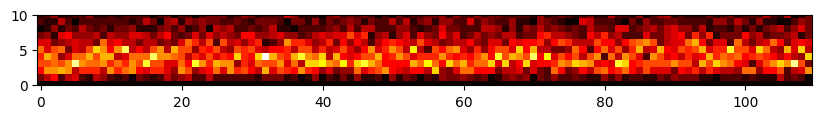

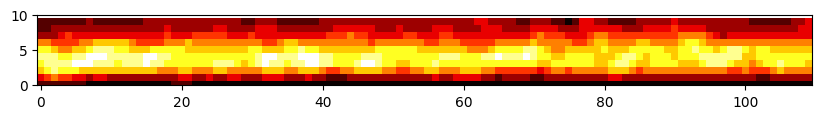

In [524]:
# heatmap of full_counts using matplitlib

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(full_counts_buffer.T, cmap='hot', interpolation='nearest', origin='lower')
plt.ylim(0, 10)
plt.show()

# apply some smoothing to the visualisation
from scipy.ndimage import gaussian_filter

trimmed_counts = full_counts_buffer.T[:10, :]
trimmed_counts = gaussian_filter(trimmed_counts, sigma=1)

plt.figure(figsize=(10, 10))
plt.imshow(trimmed_counts, cmap='hot', interpolation='nearest', origin='lower')
plt.ylim(0, 10)
plt.show()

In [494]:
all_num_steps = np.array(all_num_steps)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (550,) + inhomogeneous part.

In [421]:
all_ys = np.array(all_ys)

In [422]:
all_ys.shape

(550, 64)

In [353]:
buffer = x.select(range(64))

In [354]:
buffer

Dataset({
    features: ['problem', 'solution', 'answer', 'subject', 'level', 'unique_id', 'gold_solution_steps', '_treetune__idx', 'gold_solution_steps_str', 'query', '_treetune__reasoning_tree', '_treetune__candidate_answers', '_treetune__candidate_logprobs', '_treetune__candidate_num_tokens', 'num_steps', 'candidate_answers', 'correct', 'accuracy', 'learnability'],
    num_rows: 64
})

(array([46.,  9.,  6.,  0.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([ 1. ,  8.1, 15.2, 22.3, 29.4, 36.5, 43.6, 50.7, 57.8, 64.9, 72. ]),
 <BarContainer object of 10 artists>)

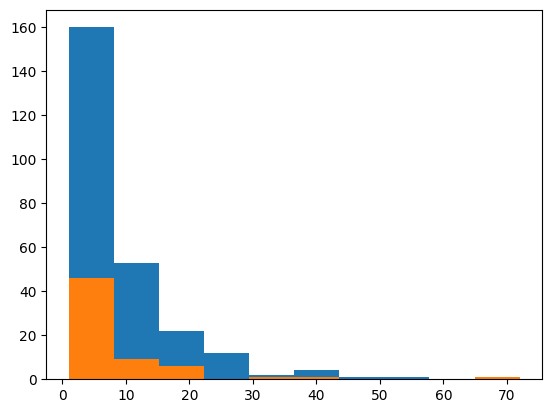

In [358]:
plt.hist(x['num_steps'])
plt.hist(buffer["num_steps"])

In [360]:
print(np.mean(x['num_steps']))
print(np.mean(buffer["num_steps"]))

9.4453125
8.390625
